In [1]:
%load_ext dotenv
%dotenv

import tqdm
import flax
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import einops
import clu
from clu import parameter_overview, metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
import orbax
from flax.training import orbax_utils
import numpy as np


2024-06-08 16:09:07.648525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialization

In [2]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1717843148.998898   13861 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717843149.022697   13861 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717843149.022819   13861 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717843149.023948   13861 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

In [3]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def set_random_key(self, seed):
        self.rng = jax.random.PRNGKey(seed)

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

In [4]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()  # Cache after augmenting to avoid recomputation
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Samplers

In [5]:
def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    scale = 1000 / timesteps
    beta_start = scale * beta_start
    beta_end = scale * beta_end
    betas = np.linspace(
        beta_start, beta_end, timesteps, dtype=np.float64)
    return betas

class NoiseScheduler():
    def __init__(self, timesteps,
                    dtype=jnp.float32,
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = timesteps
        self.dtype = dtype
        self.clip_min = clip_min
        self.clip_max = clip_max

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        raise NotImplementedError
    
    def get_p2_weights(self, k, gamma):
        raise NotImplementedError
    
    def clip_images(self, images) -> jnp.ndarray:
        raise NotImplementedError
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray]) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def get_rates(self, steps):
        raise NotImplementedError
    
    def add_noise(self, images, noise, steps, rates=None) -> jnp.ndarray:
        raise NotImplementedError
    
    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        raise NotImplementedError
    
    def transform_steps(self, steps):
        raise NotImplementedError

class DiscreteNoiseScheduler(NoiseScheduler):
    def __init__(self, timesteps,
                    beta_start=0.0001,
                    beta_end=0.02,
                    schedule_fn=linear_beta_schedule, 
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        betas = schedule_fn(timesteps, beta_start, beta_end)
        alphas = 1 - betas
        alpha_cumprod = jnp.cumprod(alphas, axis=0)
        alpha_cumprod_prev = jnp.append(1.0, alpha_cumprod[:-1])
        
        self.betas = jnp.array(betas, dtype=jnp.float32)
        self.alphas = alphas.astype(jnp.float32)
        self.alpha_cumprod = alpha_cumprod.astype(jnp.float32)
        self.alpha_cumprod_prev = alpha_cumprod_prev.astype(jnp.float32)

        self.sqrt_alpha_cumprod = jnp.sqrt(alpha_cumprod).astype(jnp.float32)
        self.sqrt_one_minus_alpha_cumprod = jnp.sqrt(1 - alpha_cumprod).astype(jnp.float32)

        self.sqrt_recip_alpha_cumprod = jnp.sqrt(1 / alpha_cumprod).astype(jnp.float32)
        self.sqrt_recip_one_minus_alpha_cumprod = jnp.sqrt(1 / alpha_cumprod - 1).astype(jnp.float32)

        posterior_variance = (betas * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod))
        self.posterior_variance = posterior_variance.astype(jnp.float32)
        self.posterior_mean_coef1 = (betas * jnp.sqrt(alpha_cumprod_prev) / (1 - alpha_cumprod)).astype(jnp.float32)

        self.posterior_mean_coef2 = ((1 - alpha_cumprod_prev) * jnp.sqrt(alphas) / (1 - alpha_cumprod)).astype(jnp.float32)
        self.posterior_log_variance_clipped = (jnp.log(jnp.maximum(posterior_variance, 1e-20))).astype(jnp.float32)

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        rand = jax.random.uniform(rng, (batch_size,), minval=0., maxval=1, dtype=jnp.float32)
        # Scale the random values to the range [0, max_timesteps]
        return jnp.floor(rand * self.max_timesteps).astype(jnp.int32), state
    
    def get_p2_weights(self, k, gamma):
        return (k + self.alpha_cumprod / (1 - self.alpha_cumprod)) ** -gamma
    
    def clip_images(self, images) -> jnp.ndarray:
        return jnp.clip(images, self.clip_min, self.clip_max)
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray]) -> tuple[jnp.ndarray, jnp.ndarray]:
        signal_rates, noise_rates = rates
        signal_rates = jnp.reshape(signal_rates, (-1, 1, 1, 1))
        noise_rates = jnp.reshape(noise_rates, (-1, 1, 1, 1))
        return signal_rates, noise_rates

    def get_rates(self, steps):
        signal_rate = self.sqrt_alpha_cumprod[steps]
        noise_rate = self.sqrt_one_minus_alpha_cumprod[steps]
        return signal_rate, noise_rate
    
    # Used while training
    def add_noise(self, images, noise, steps, rates=None) -> jnp.ndarray:
        if rates is None:
            rates = self.get_rates(steps)
        signal_rates, noise_rates = self.reshape_rates(rates)
        return signal_rates * images + noise_rates * noise

    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        # Scale 't' to the range [0, 1]
        if rates == None:
            signal_coeff = self.sqrt_recip_alpha_cumprod[steps]
            noise_coeff = self.sqrt_recip_one_minus_alpha_cumprod[steps]
            signal_coeff, noise_coeff = self.reshape_rates((signal_coeff, noise_coeff))
            pred_images = signal_coeff * noisy_images - noise_coeff * noise
        else:
            signal_rate, noise_rate = rates
            signal_rate, noise_rate = self.reshape_rates((signal_rate, noise_rate))
            pred_images = (noisy_images - noise_rate * noise) / signal_rate
        if clip_denoised:
            pred_images = jnp.clip(pred_images, -1, 1)
        return pred_images
    
    # Used while training
    def transform_steps(self, steps):
        return steps #/ self.max_timesteps

class CosineNoiseSchedule(DiscreteNoiseScheduler):
    def __init__(self, timesteps, beta_start=0.008, beta_end=0.999, *args, **kwargs):
        super().__init__(timesteps, beta_start, beta_end, schedule_fn=cosine_beta_schedule, *args, **kwargs)

class LinearNoiseSchedule(DiscreteNoiseScheduler):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, *args, **kwargs):
        super().__init__(timesteps, beta_start, beta_end, schedule_fn=linear_beta_schedule, *args, **kwargs)

2.7537346e-05


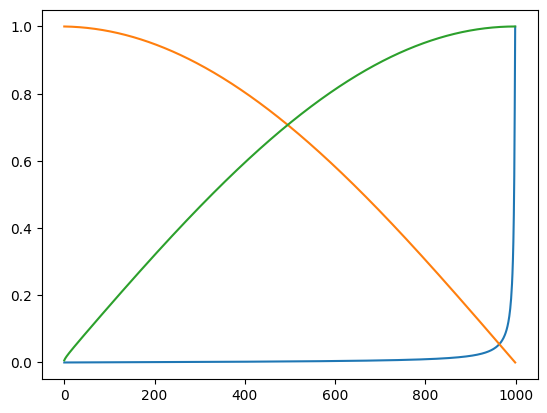

In [6]:
schedule = CosineNoiseSchedule(1000)
plt.plot(schedule.betas)
# plt.plot(sampler.alphas)
# plt.plot(sampler.alpha_cumprod)
# plt.plot(sampler.alpha_cumprod_prev)
plt.plot([schedule.get_rates(i) for i in range(1000)])
deltas = []
for i in range(1000):
    signal, noise = schedule.get_rates(i)
    deltas.append(jnp.abs(1 - (signal**2 + noise**2)))
print(sum(deltas))

# Data Diffusion Testing

2024-06-08 15:49:55.086112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


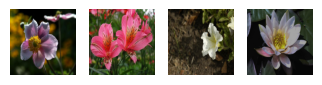

/tmp/ipykernel_4165/2679090366.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float64)


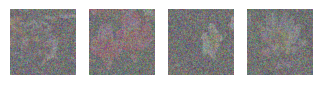

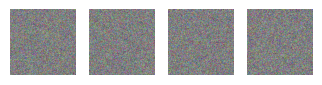

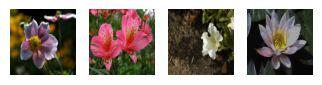

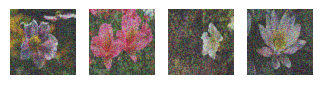

(Array(0.80373377, dtype=float32), Array(0.5949891, dtype=float32))


In [24]:
# Visualize adding some noise to some sample images and then removing it
state = RandomMarkovState(jax.random.PRNGKey(4))
data, _ = get_dataset("oxford_flowers102", batch_size=4, image_scale=256)
images = next(iter(data))
plotImages(images)
noise_level = 400# * jnp.ones((images.shape[0], ), dtype=jnp.int32)
noise_level_max = 1000
schedule = CosineNoiseSchedule(noise_level_max)
sampler = DDPMSampler(schedule)
state, rng = state.get_random_key()
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
plotImages(noisy_images)
plotImages(noise)
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)

# Now test sampling
# sample = jax.random.normal(random.get_random_key(), shape=images.shape, dtype=jnp.float64)
sample = noisy_images
for i in reversed(range(0, noise_level)):
    step = jnp.ones((images.shape[0], 1, 1, 1), dtype=jnp.int32) * i
    sample, state = sampler.sample_step(sample, noise, step, state=state)
        # sample = schedule.remove_all_noise(sample, noise, step, clip_denoised=False)

plotImages(sample)
print(schedule.get_rates(noise_level))

# Modeling

## Metrics

## Callbacks

## Model Generator

In [6]:
class WeightStandardizedConv(nn.Module):
    """
    apply weight standardization  https://arxiv.org/abs/1903.10520
    """ 
    features: int
    kernel_size: Sequence[int] = 3
    strides: Union[None, int, Sequence[int]] = 1
    padding: Any = 1
    dtype: Any = jnp.float32
    param_dtype: Any = jnp.float32


    @nn.compact
    def __call__(self, x):
        """
        Applies a weight standardized convolution to the inputs.

        Args:
          inputs: input data with dimensions (batch, spatial_dims..., features).

        Returns:
          The convolved data.
        """
        x = x.astype(self.dtype)
        
        conv = nn.Conv(
            features=self.features, 
            kernel_size=self.kernel_size, 
            strides = self.strides,
            padding=self.padding, 
            dtype=self.dtype, 
            param_dtype = self.param_dtype,
            parent=None)
        
        kernel_init = lambda  rng, x: conv.init(rng,x)['params']['kernel']
        bias_init = lambda  rng, x: conv.init(rng,x)['params']['bias']
        
        # standardize kernel
        kernel = self.param('kernel', kernel_init, x)
        eps = 1e-5 if self.dtype == jnp.float32 else 1e-3
        # reduce over dim_out
        redux = tuple(range(kernel.ndim - 1))
        mean = jnp.mean(kernel, axis=redux, dtype=self.dtype, keepdims=True)
        var = jnp.var(kernel, axis=redux, dtype=self.dtype, keepdims=True)
        standardized_kernel = (kernel - mean)/jnp.sqrt(var + eps)

        bias = self.param('bias',bias_init, x)

        return(conv.apply({'params': {'kernel': standardized_kernel, 'bias': bias}},x))
    

In [14]:
# Built using the Flax NNX library

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="normal")

class PixelShuffle(nn.Module):
    scale: int

    @nn.compact
    def __call__(self, x):
        up = einops.rearrange(
            x,
            pattern="b h w (h2 w2 c) -> b (h h2) (w w2) c",
            h2=self.scale,
            w2=self.scale,
        )
        return up
    
class TimeEmbedding(nn.Module):
    features:int
    max_timesteps:int=10000

    def setup(self):
        # self.embeddings = nn.Embed(
        #     num_embeddings=max_timesteps, features=out_features
        # )
        half_dim = self.features // 2
        emb = jnp.log(self.max_timesteps) / (half_dim - 1)
        emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        self.embeddings = emb
    
    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * self.embeddings[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb
    
class TimeProjection(nn.Module):
    features:int
    activation:Callable=jax.nn.gelu

    @nn.compact
    def __call__(self, x):
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        return x
    
class SeparableConv(nn.Module):
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    use_bias:bool=False
    kernel_init:Callable=kernel_init(1.0)
    padding:str="SAME"
    
    @nn.compact
    def __call__(self, x):
        in_features = x.shape[-1]
        depthwise = nn.Conv(
            features=in_features, kernel_size=self.kernel_size,
            strides=self.strides, kernel_init=self.kernel_init,
            feature_group_count=in_features, use_bias=self.use_bias,
            padding=self.padding
        )(x)
        pointwise = nn.Conv(
            features=self.features, kernel_size=(1, 1),
            strides=(1, 1), kernel_init=self.kernel_init,
            use_bias=self.use_bias
        )(depthwise)
        return pointwise


class ConvLayer(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    kernel_init:Callable=kernel_init(1.0)

    def setup(self):
        # conv_type can be "conv", "separable", "conv_transpose"
        if self.conv_type == "conv":
            self.conv = nn.Conv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "w_conv":
            self.conv = WeightStandardizedConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                padding="SAME",
                dtype=jnp.float32,
                param_dtype=jnp.float32
            )
        elif self.conv_type == "separable":
            self.conv = SeparableConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "conv_transpose":
            self.conv = nn.ConvTranspose(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )

    def __call__(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.mish

    @nn.compact
    def __call__(self, x, residual=None):
        out = x
        out = PixelShuffle(scale=self.scale)(out)
        # B, H, W, C = x.shape
        # out = jax.image.resize(x, (B, H * self.scale, W * self.scale, C), method="nearest")
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(1, 1),
        )(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out
    
class Downsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.mish
    
    @nn.compact
    def __call__(self, x, residual=None):
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(2, 2)
        )(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nn.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out
    
class CrossAttention(nn.Module):
    num_heads: int
    head_dim: int
    kernel_init: Callable = kernel_init(1.0)

    @nn.compact
    def __call__(self, x, context):
        q = nn.Dense(self.num_heads * self.head_dim, kernel_init=self.kernel_init)(x)
        k = nn.Dense(self.num_heads * self.head_dim, kernel_init=self.kernel_init)(context)
        v = nn.Dense(self.num_heads * self.head_dim, kernel_init=self.kernel_init)(context)

        q = q.reshape(x.shape[0], -1, self.num_heads, self.head_dim)
        k = k.reshape(context.shape[0], -1, self.num_heads, self.head_dim)
        v = v.reshape(context.shape[0], -1, self.num_heads, self.head_dim)

        attn_weights = jnp.einsum('bqhd,bkhd->bhqk', q, k)
        attn_weights = nn.softmax(attn_weights, axis=-1)

        attn_output = jnp.einsum('bhqk,bkhd->bqhd', attn_weights, v)
        attn_output = attn_output.reshape(x.shape[0], -1, self.num_heads * self.head_dim)

        return nn.Dense(x.shape[-1])(attn_output)
    
class AttentionBlock(nn.Module):
    attention_config:Dict[str, Any]
    kernel_init:Callable=kernel_init(1.0)
    attention_fn:Callable=nn.MultiHeadAttention
    attention_kwargs:Dict[str, Any]=field(default_factory=dict)

    def setup(self) -> None:
        if self.attention_config.get('attention_fn', None) != None:
            self.attention_fn = self.attention_config['attention_fn']
        return 

    @nn.compact
    def __call__(self, x):
        attention = self.attention_fn(**self.attention_config, kernel_init=self.kernel_init, decode=False)(x)
        out = x + attention
        return out

class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.mish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(8)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type, 
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
        )(out)
        out = nn.GroupNorm(8)(out)

        temb = nn.DenseGeneral(features=self.features*2)(temb)[:, None, None, :]
        scale, shift = jnp.split(temb, 2, axis=-1)
        out = out * (1 + scale) + shift

        out = self.activation(out)

        out = ConvLayer(
            self.conv_type, 
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type, 
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 96, 128, 160, 192],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=1,
    activation:Callable = jax.nn.mish

    @nn.compact
    def __call__(self, x, temb):
        temb = TimeEmbedding(self.emb_features)(temb)
        temb = TimeProjection(self.emb_features)(temb)
        # print("time embedding", temb.shape)
        feature_depths = self.feature_depths[:-1]
        attention_configs = self.attention_configs[:-1]
        x = ConvLayer(
            "conv",
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]
        for i, (features, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    "conv", 
                    features=features,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                )(x, temb, x)
                if attention_config is not None:
                    x = AttentionBlock(attention_config=attention_config)(x)
                downs.append(x)
            x = Downsample(
                features=features,
                scale=2,
                activation=self.activation,
            )(x)
            if i != len(feature_depths) - 1:
                downs.append(x)
        middle_features = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        for j in range(self.num_res_blocks):
            x = ResidualBlock(
                "separable", 
                features=middle_features,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
            )(x, temb, x)
            if middle_attention is not None:
                x = AttentionBlock(attention_config=middle_attention)(x)
            x = ResidualBlock(
                "separable", 
                features=middle_features,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
            )(x, temb, x)

        for i, (features, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            x = Upsample(
                features=features,
                scale=2,
                activation=self.activation,
            )(x)
            for j in range(self.num_res_blocks + 1):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                x = ResidualBlock(
                    "conv", 
                    features=features,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                )(x, temb, x)
            if attention_config is not None:
                x = AttentionBlock(attention_config=attention_config)(x)

        x = nn.GroupNorm(8)(x)
        x = self.activation(x)
        x = ConvLayer(
            "conv",
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return x

# Training

In [15]:
BATCH_SIZE = 16
IMAGE_SIZE = 64

cosine_schedule = CosineNoiseSchedule(1000)
linear_schedule = LinearNoiseSchedule(1000)

In [16]:
import orbax.checkpoint


@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

class TrainState(train_state.TrainState):
    rngs:jax.random.PRNGKey
    
    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

class DiffusionTrainer:
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 p2_loss_weight_k:float=1,
                 p2_loss_weight_gamma:float=1,
                 ):
        self.model = model
        self.state:TrainState = None
        self.noise_schedule = noise_schedule
        self.name = name
        self.p2_loss_weights = self.noise_schedule.get_p2_weights(p2_loss_weight_k, p2_loss_weight_gamma)

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            params, model = self.load()
        else:
            params = None

        if train_state == None:
            self.init_state(optimizer, rngs, params=params, model=model)
        else:
            train_state.params = params
            self.state = train_state

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   params:dict=None,
                   model:nn.Module=None,
                   ):
        inp = jnp.ones((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((BATCH_SIZE,))
        rngs, subkey = jax.random.split(rngs)
        if params == None:
            params = model.init(subkey, inp, temb)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=optimizer,
            rngs=rngs,
        )
        self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./models'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state.get('params', None), ckpt.get('model', None)

    def save(self, epoch=0, best=False):
        print(f"Saving model at epoch {epoch}")
        state = self.best_state if best else self.state
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        p2_loss_weights = self.p2_loss_weights
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            noisy_images = noise_schedule.add_noise(images, noise, noise_level)
            def loss_fn(params):
                pred_noises:jax.Array = model.apply(params, noisy_images, noise_schedule.transform_steps(noise_level))
                # loss = jnp.mean(optax.squared_error(pred_noises.reshape((1, -1)), noise.reshape((1, -1))), axis=1)
                # loss *= p2_loss_weights[noise_level]
                loss = jnp.mean(optax.l2_loss(pred_noises - noise))
                # loss = jnp.mean(loss)
                return loss
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads) 
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch, best=True)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Avg time per step: {avg_time_per_step:.5f}s")
        return self.state


In [17]:
# experiment_name='DiffusionDDPM_2024-06-08_14:56:27'
# print("Experiment_Name:", experiment_name)
# unet = Unet(emb_features=256, 
#             feature_depths=[64, 96, 128, 192], 
#             attention_configs=[{"num_heads":1}, {"num_heads":1}, {"num_heads":4}, {"num_heads":4}],
#             # attention_configs=[None]*4, 
#             num_res_blocks=1)
# trainer = DiffusionTrainer(unet, optimizer=optax.adam(2e-4), 
#                             noise_schedule=cosine_schedule,
#                            sampler=ddpm_sampler, rngs=jax.random.PRNGKey(4), 
#                            name=experiment_name,
#                            load_from_checkpoint=True
#                            )
# #trainer.summary()
# data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)

In [18]:
experiment_name = "{name}_{date}".format(
    name="Diffusion", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256, 
            feature_depths=[64, 96, 128, 192], 
            attention_configs=[{"num_heads":1}, {"num_heads":1}, {"num_heads":4}, {"num_heads":4}],
            # attention_configs=[None]*4, 
            num_res_blocks=1)
trainer = DiffusionTrainer(unet, optimizer=optax.adam(2e-4), 
                           noise_schedule=cosine_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           )
#trainer.summary()

Experiment_Name: Diffusion_2024-06-08_16:13:03


In [19]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, datalen // BATCH_SIZE, epochs=100)


Epoch 1/100


		Epoch 1: 600step [00:54, 11.10step/s, loss=0.0502]                                                


Saving model at epoch 0

	Epoch 1 completed. Avg Loss: 0.06998736411333084, Time: 54.05s, Avg time per step: 0.10577s

Epoch 2/100


		Epoch 2: 600step [00:25, 23.12step/s, loss=0.0524]                                                


Saving model at epoch 1

	Epoch 2 completed. Avg Loss: 0.04299560934305191, Time: 25.95s, Avg time per step: 0.05078s

Epoch 3/100


		Epoch 3: 600step [00:25, 23.61step/s, loss=0.0381]                                                


Saving model at epoch 2

	Epoch 3 completed. Avg Loss: 0.04046352207660675, Time: 25.42s, Avg time per step: 0.04974s

Epoch 4/100


		Epoch 4: 600step [00:25, 23.51step/s, loss=0.0535]                                                


Saving model at epoch 3

	Epoch 4 completed. Avg Loss: 0.03858938440680504, Time: 25.52s, Avg time per step: 0.04995s

Epoch 5/100


		Epoch 5: 600step [00:25, 23.39step/s, loss=0.0320]                                                


Saving model at epoch 4

	Epoch 5 completed. Avg Loss: 0.038340236991643906, Time: 25.66s, Avg time per step: 0.05021s

Epoch 6/100


		Epoch 6: 600step [00:25, 23.74step/s, loss=0.0443]                                                


Saving model at epoch 5

	Epoch 6 completed. Avg Loss: 0.03684799373149872, Time: 25.27s, Avg time per step: 0.04946s

Epoch 7/100


		Epoch 7: 600step [00:24, 24.29step/s, loss=0.0377]                                                


Saving model at epoch 6

	Epoch 7 completed. Avg Loss: 0.036199335008859634, Time: 24.70s, Avg time per step: 0.04834s

Epoch 8/100


		Epoch 8: 600step [00:24, 24.16step/s, loss=0.0224]                                                


Saving model at epoch 7

	Epoch 8 completed. Avg Loss: 0.03535337746143341, Time: 24.84s, Avg time per step: 0.04861s

Epoch 9/100


		Epoch 9: 600step [00:24, 24.39step/s, loss=0.0516]                                                



	Epoch 9 completed. Avg Loss: 0.035372406244277954, Time: 24.60s, Avg time per step: 0.04815s

Epoch 10/100


		Epoch 10: 600step [00:24, 24.38step/s, loss=0.0254]                                               



	Epoch 10 completed. Avg Loss: 0.03557386249303818, Time: 24.61s, Avg time per step: 0.04817s

Epoch 11/100


		Epoch 11: 600step [00:24, 24.35step/s, loss=0.0284]                                               


Saving model at epoch 10

	Epoch 11 completed. Avg Loss: 0.0344245545566082, Time: 24.64s, Avg time per step: 0.04822s

Epoch 12/100


		Epoch 12: 600step [00:24, 24.30step/s, loss=0.0176]                                               



	Epoch 12 completed. Avg Loss: 0.035373929888010025, Time: 24.70s, Avg time per step: 0.04833s

Epoch 13/100


		Epoch 13: 600step [00:24, 24.41step/s, loss=0.0151]                                               



	Epoch 13 completed. Avg Loss: 0.03445912525057793, Time: 24.58s, Avg time per step: 0.04810s

Epoch 14/100


		Epoch 14: 600step [00:24, 24.52step/s, loss=0.0350]                                               


Saving model at epoch 13

	Epoch 14 completed. Avg Loss: 0.03440973907709122, Time: 24.47s, Avg time per step: 0.04789s

Epoch 15/100


		Epoch 15: 600step [00:24, 24.38step/s, loss=0.0287]                                               


Saving model at epoch 14

	Epoch 15 completed. Avg Loss: 0.03371451795101166, Time: 24.61s, Avg time per step: 0.04817s

Epoch 16/100


		Epoch 16: 600step [00:24, 24.35step/s, loss=0.0443]                                               



	Epoch 16 completed. Avg Loss: 0.03400749713182449, Time: 24.64s, Avg time per step: 0.04823s

Epoch 17/100


		Epoch 17: 600step [00:25, 23.61step/s, loss=0.0388]                                               


Saving model at epoch 16

	Epoch 17 completed. Avg Loss: 0.03271649405360222, Time: 25.41s, Avg time per step: 0.04973s

Epoch 18/100


		Epoch 18: 600step [00:25, 23.18step/s, loss=0.0306]                                               



	Epoch 18 completed. Avg Loss: 0.03320259973406792, Time: 25.88s, Avg time per step: 0.05065s

Epoch 19/100


		Epoch 19: 600step [00:27, 22.12step/s, loss=0.0394]                                               



	Epoch 19 completed. Avg Loss: 0.033240631222724915, Time: 27.13s, Avg time per step: 0.05309s

Epoch 20/100


		Epoch 20: 600step [00:26, 23.03step/s, loss=0.0302]                                               


Saving model at epoch 19

	Epoch 20 completed. Avg Loss: 0.03231718763709068, Time: 26.05s, Avg time per step: 0.05098s

Epoch 21/100


		Epoch 21: 600step [00:25, 23.21step/s, loss=0.0284]                                               



	Epoch 21 completed. Avg Loss: 0.03347449004650116, Time: 25.85s, Avg time per step: 0.05058s

Epoch 22/100


		Epoch 22: 600step [00:26, 22.75step/s, loss=0.0324]                                               



	Epoch 22 completed. Avg Loss: 0.03345039486885071, Time: 26.38s, Avg time per step: 0.05162s

Epoch 23/100


		Epoch 23:  78%|██████████████████████████▌       | 400/511 [00:15<00:04, 23.58step/s, loss=0.0156]

In [ ]:
class DiffusionSampler():   
    # Used to sample from the diffusion model
    # This is a markov chain, so we need to sample from the posterior
    def sample_step(self, noise_schedule:NoiseScheduler, current_samples, pred_noise, steps, step_size=1, clip_denoised=True, 
                    last_step=False, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        signal_rates, noise_rates = noise_schedule.get_rates(steps)
        # First clip the noisy images
        pred_images = noise_schedule.remove_all_noise(current_samples, pred_noise, steps, clip_denoised, rates=(signal_rates, noise_rates))
        # Now add some noise back to the clean images
        if last_step == True:
            return pred_images, state

        return self._renoise(noise_schedule, pred_images, current_samples, pred_noise, steps, step_size=step_size, state=state)

    def _renoise(self, noise_schedule:NoiseScheduler, reconstructed_samples, current_samples, 
                 pred_noise, steps, state:RandomMarkovState, step_size=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        return NotImplementedError

    # Used while training
    def transform_steps(self, steps):
        return steps
    
    def generate_images(self, model:nn.Module, params, 
                        noise_schedule:NoiseScheduler,
                        num_images=16, diffusion_steps=1000, 
                        priors=None, rngstate:RandomMarkovState=RandomMarkovState()) -> jnp.ndarray:
        if priors == None:
            rngs, newrngs = rngstate.get_random_key()
            rngstate = RandomMarkovState(rngs)
            samples = jax.random.normal(newrngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3))
        else:
            samples = priors
        
        step_ones = jnp.ones((num_images, ), dtype=jnp.int32)

        @jax.jit
        def sample_step(state:RandomMarkovState, samples, step, step_size):
            step = step_ones * step
            pred_noises = model.apply(params, samples, noise_schedule.transform_steps(step))
            samples, state = self.sample_step(noise_schedule, samples, pred_noises, step, state=state, step_size=step_size)
            return samples, state

        step_size = noise_schedule.max_timesteps / diffusion_steps

        for i in tqdm.tqdm(reversed(range(0, diffusion_steps))):
            samples, rngstate = sample_step(rngstate, samples, int(i * step_size), int(step_size))
        # Clip the images
        samples = noise_schedule.clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def _renoise(self, 
                 noise_schedule:DiscreteNoiseScheduler, reconstructed_samples, current_samples, 
                 pred_noise, steps, state:RandomMarkovState, step_size=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # First estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        signal_mean = noise_schedule.posterior_mean_coef1[steps]
        noise_mean = noise_schedule.posterior_mean_coef2[steps]
        signal_mean, noise_mean = noise_schedule.reshape_rates((signal_mean, noise_mean))

        mean = signal_mean * reconstructed_samples + noise_mean * current_samples
    
        log_variance_clipped = noise_schedule.posterior_log_variance_clipped[steps].reshape(-1, 1, 1, 1)

        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)
        
        non_zero_mask = (1 - jnp.equal(steps, 0).astype(jnp.float32)).reshape(-1, 1, 1, 1)
        return mean + noise * jnp.exp(0.5 * log_variance_clipped) * non_zero_mask, state

class DDIMSampler(DiffusionSampler):
    def _renoise(self, 
                 noise_schedule:NoiseScheduler, reconstructed_samples, current_samples, 
                 pred_noise, steps, state:MarkovState, step_size=1) -> tuple[jnp.ndarray, MarkovState]:
        next_steps = jnp.maximum(steps - step_size, 0)
        return noise_schedule.add_noise(reconstructed_samples, pred_noise, next_steps), state

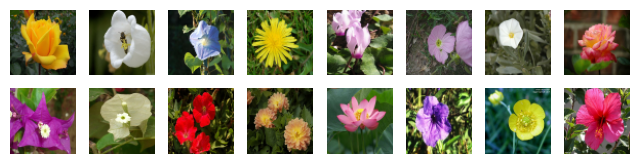

(16, 64, 64, 3)


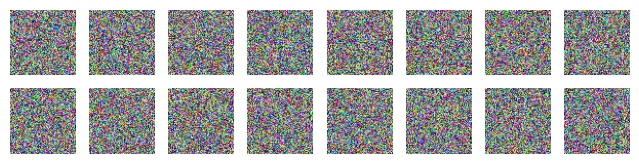

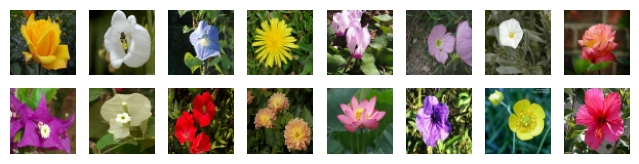

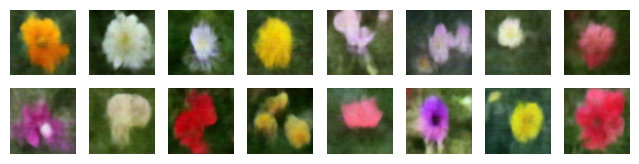

500it [00:18, 27.60it/s]


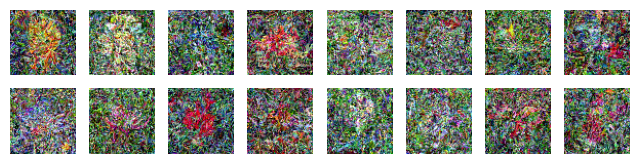

In [14]:
images = next(iter(data))
plotImages(images)
print(images.shape)
rng = jax.random.PRNGKey(4)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float32)
noise_level = 500
noise_levels = jnp.ones((images.shape[0],), dtype=jnp.int32) * noise_level
sampler = DDIMSampler()
noise_schedule = trainer.noise_schedule
noisy_images = noise_schedule.add_noise(images, noise, noise_levels)
plotImages(noisy_images)
regenerated_images = noise_schedule.remove_all_noise(noisy_images, noise, noise_levels)
plotImages(regenerated_images)
pred_noise = unet.apply(trainer.state.params, noisy_images, sampler.transform_steps(noise_levels))
reconstructed_images = noise_schedule.remove_all_noise(noisy_images, pred_noise, noise_levels)
plotImages(reconstructed_images)
samples = sampler.generate_images(trainer.model, trainer.state.params, noise_schedule, num_images=BATCH_SIZE, diffusion_steps=1000, priors=noisy_images)
plotImages(samples)

1000it [00:42, 23.27it/s]


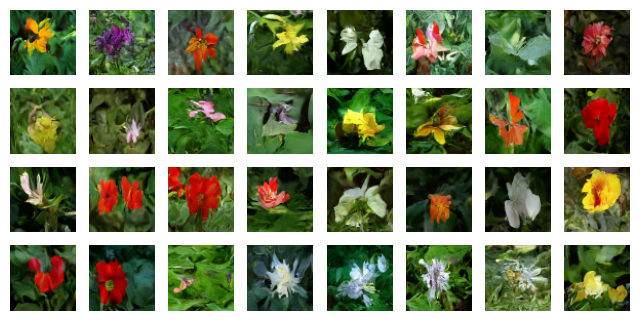

In [15]:
sampler = DDPMSampler()
samples = sampler.generate_images(trainer.model, trainer.state.params, noise_schedule, num_images=BATCH_SIZE, diffusion_steps=1000, priors=None)
plotImages(samples)

100it [00:06, 16.05it/s]


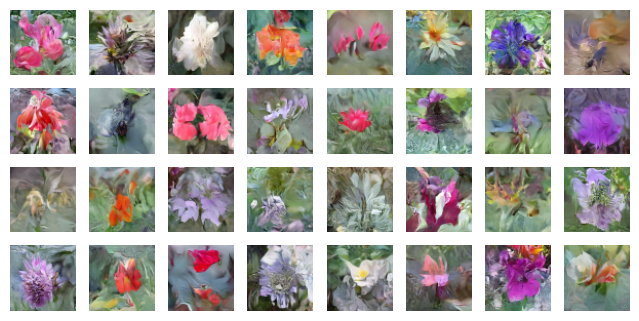

In [17]:
sampler = DDIMSampler()
samples = sampler.generate_images(trainer.model, trainer.state.params, noise_schedule, num_images=BATCH_SIZE, diffusion_steps=100, priors=noisy_images)
plotImages(samples)

1000it [00:12, 79.01it/s]


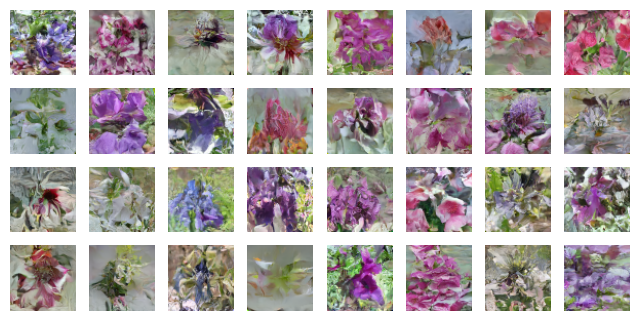

In [53]:
schedule = DDIMSampler(timesteps=1000, schedule_fn=cosine_beta_schedule, beta_start=0.008, beta_end=0.999)
trainer.schedule = schedule
samples = trainer.generate_images(num_images=32, diffusion_steps=1000, priors=None, use_best=True)
plotImages(samples)

1000it [00:12, 82.85it/s]


Samples (64, 64, 64, 3) -0.99983406 0.99983406 -0.3262726


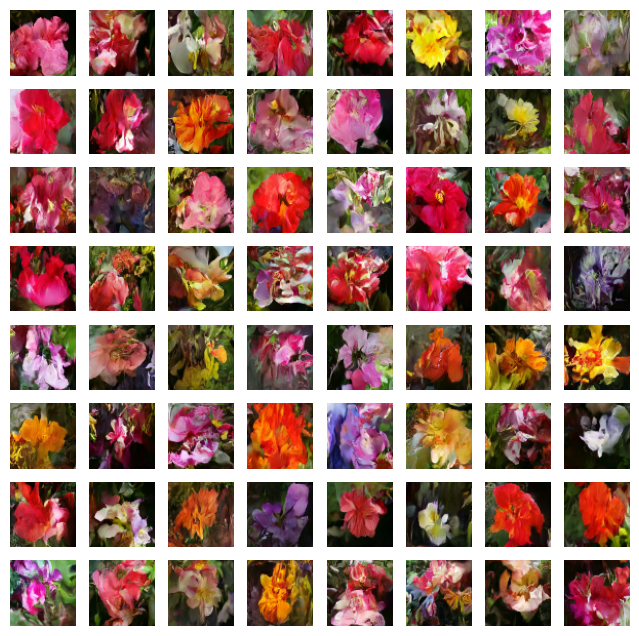

In [26]:
samples = generate_images(trainer.state, trainer.schedule, num_images=64, diffusion_steps=1000)
plotImages(samples)